In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [87]:
df = pd.read_csv("/content/drug200.csv")

In [88]:
print("Dataset Info:")
print(df.info())
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB
None


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [89]:
print(df.isnull().sum())

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64


In [90]:
duplicates = df.duplicated().sum()

In [91]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} outliers capped")

    df[col] = df[col].clip(lower=lower, upper=upper)

Age: 0 outliers capped
Na_to_K: 8 outliers capped


In [92]:
target_column = "Drug"
X = df.drop(columns=[target_column])
y = df[target_column]


In [93]:
# Encode categorical columns
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

if y.dtype == 'object':
    le_y = LabelEncoder()
    y = le_y.fit_transform(y)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
tree = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)

In [96]:
print("Training Accuracy:", tree.score(X_train, y_train))
print("Testing Accuracy:", tree.score(X_test, y_test))

Training Accuracy: 1.0
Testing Accuracy: 1.0


In [97]:
y_pred = tree.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        15

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



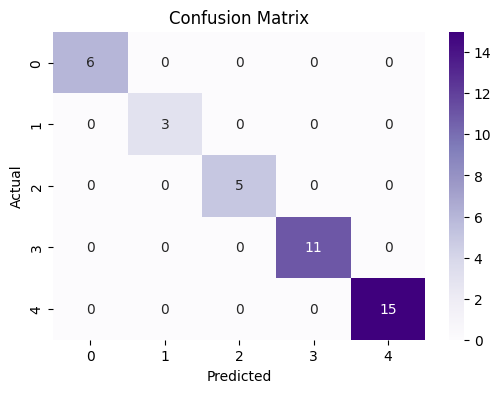

In [98]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


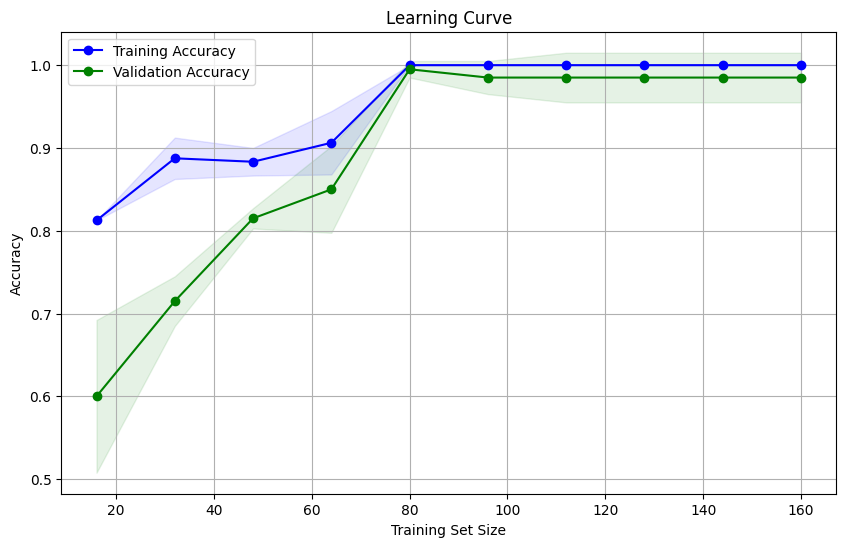

In [99]:
train_sizes, train_scores, test_scores = learning_curve(
    tree, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy', color='green')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


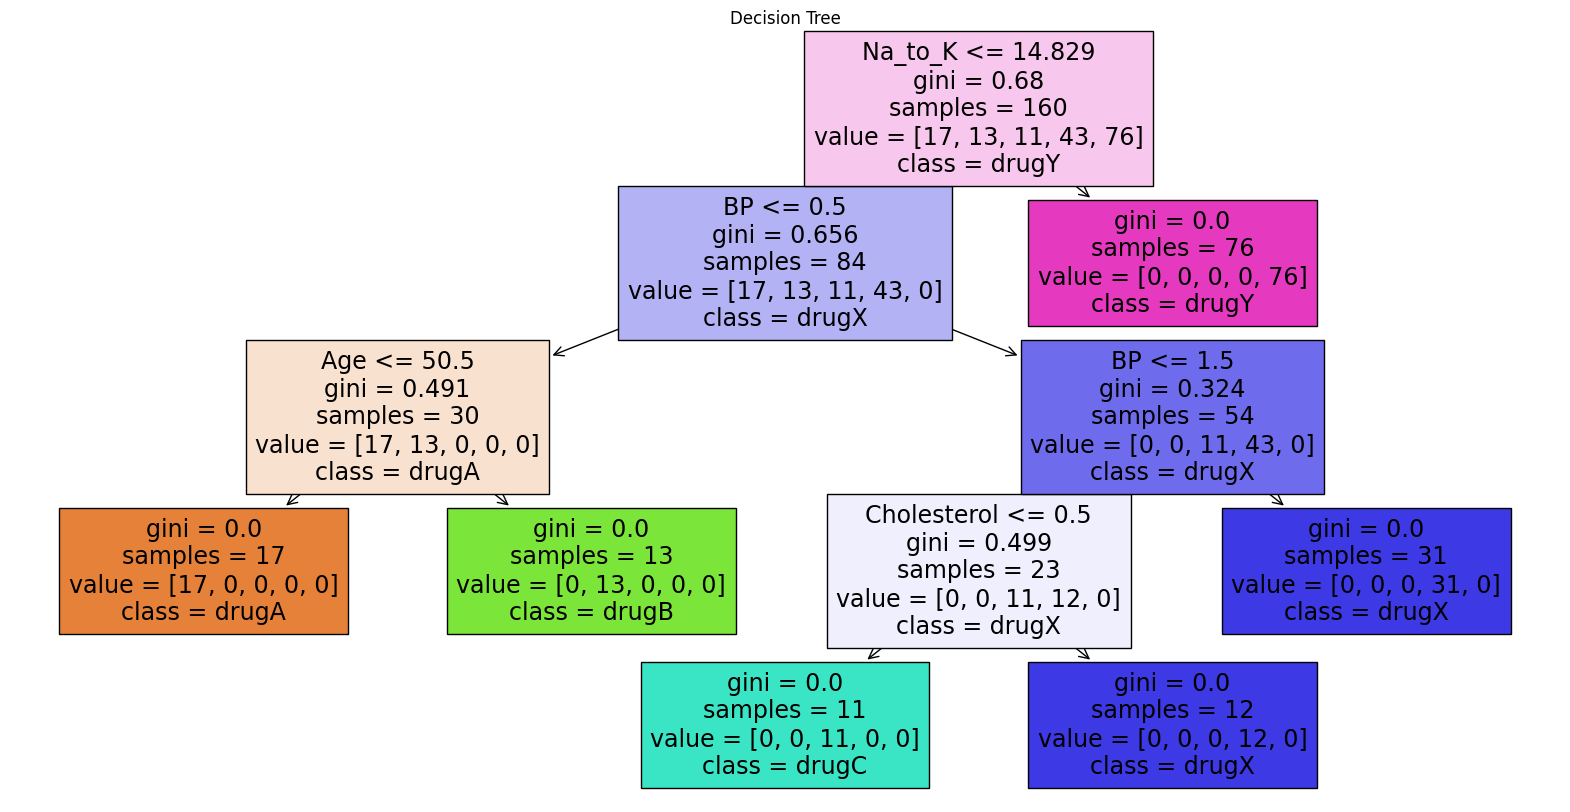

In [100]:
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, class_names=le_y.classes_, filled=True)
plt.title("Decision Tree")
plt.show()

In [101]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9875


In [108]:
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42),
    'Logistic Regression': LogisticRegression(C=0.1, penalty='l2', max_iter=2000),
    'SVM': SVC(kernel='linear', C=10,gamma='scale')
}



In [109]:
for name, model in models.items():
    print(f"\n----- {name} -----")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Training Accuracy:", model.score(X_train, y_train))
    print("Testing Accuracy:", model.score(X_test, y_test))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


----- Decision Tree -----
Training Accuracy: 1.0
Testing Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        15

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


----- Logistic Regression -----
Training Accuracy: 0.89375
Testing Accuracy: 0.825

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.60      1.00      0.75         3
           2       0.00      0.00      0.00         5
           3       0.69      0.82      0.75        11
           4       1.00      1.00 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
